# 	基于深度学习的细胞类型聚类
第五小组：刘荟文2114019、孙蕗2112060、郭裕彬2114052
## 实验要求：
实验数据：dataset1（无真实标签）、dataset2（有真实细胞类型标签）。

基础要求(20)：使用简单的深度学习的方法对数据进行细胞类型聚类，得到多个亚群，完成实验报告（最好使用ipynb文件，包括但不限于代码、模型设计思路、模型架构图、聚类效果展示、实验分析等），并以csv文件提交最终的dataset1数据聚类结果（聚类编号从0到k，k为算法计算的k个潜在细胞群）。

中级要求(5)：使用你的方法在dataset2上做实验，dataset2有真实的细胞类型标签，你可以对你的方法进行自我评估，并且分析结果，可以体现你的模型改进过程。展示你计算的Adjusted Rand Score指标。

高级要求(5): 使用较为复杂的神经网络进行细胞类型聚类。如复现相关论文，用到你的网络中进行复现等。

加分项(5)：基础要求的结果会通过Adjusted Rand Score指标进行评分，排名靠前会有额外得分。

大作业最高分为30分，鼓励组队，最多五人一队，也可单人成队。注意dataset1和dataset2虽然是同属于转录组数据，但是之间存在批次效应，最好不要考虑参考dataset2的真实标签来调整dataset1的结果。该任务是无监督的聚类任务，其训练集和测试集是一致的，不是传统的需要划分训练、验证和测试集的任务。


## 实验内容
### 总体设计

经由小组同学的多次尝试和讨论探究，最终选择参考论文Attention-based deep clustering method for scRNA-seq cell type identification（https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011641#sec002） 中提出的 AttentionAE-sc (Attention fusion AutoEncoder for single-cell)方法。

AttentionAE-sc方法的设计思路主要包括两个组件：一个基于自编码器的降维网络和一个基于图卷积神经网络的图嵌入网络，这两个组件通过注意力机制进行整合，以实现更准确的聚类结果，其模型架构组成为：

1. 自编码器（DAE）被用来处理scRNA-seq数据集的稀疏性和dropout事件。DAE的输入是原始的scRNA-seq数据，输出是一个重构的版本，其中包含了对数据的噪声去除和特征提取。DAE的输出被用作AttentionAE-sc方法的第一个嵌入向量。 
2. 图卷积神经网络（GAE）被用来处理scRNA-seq数据集的高维度问题。GAE的输入是一个邻接矩阵，其中每个元素表示两个细胞之间的相似度。GAE的输出是一个嵌入向量，其中每个维度表示一个细胞的特征。GAE的输出被用作AttentionAE-sc方法的第二个嵌入向量。 
3. 注意力机制被用来整合DAE和GAE的嵌入向量。具体来说，AttentionAE-sc方法使用多头注意力机制来计算每个细胞的注意力权重，以确定哪个嵌入向量对于该细胞更重要。然后，这些嵌入向量被加权平均，以获得最终的嵌入向量。这个嵌入向量被用来进行聚类分析。 
4. 在聚类分析中，AttentionAE-sc方法使用自优化聚类（DEC）算法来确定细胞的子群。DEC算法通过最小化嵌入向量和聚类中心之间的距离来确定聚类结果。为了避免指定聚类数，AttentionAE-sc方法使用Leiden算法来初始化聚类中心。 

总的来说，AttentionAE-sc方法的设计思路是通过整合自编码器和图卷积神经网络的嵌入向量，并使用注意力机制来确定每个嵌入向量的重要性，以实现更准确的聚类结果。

### 模型架构图

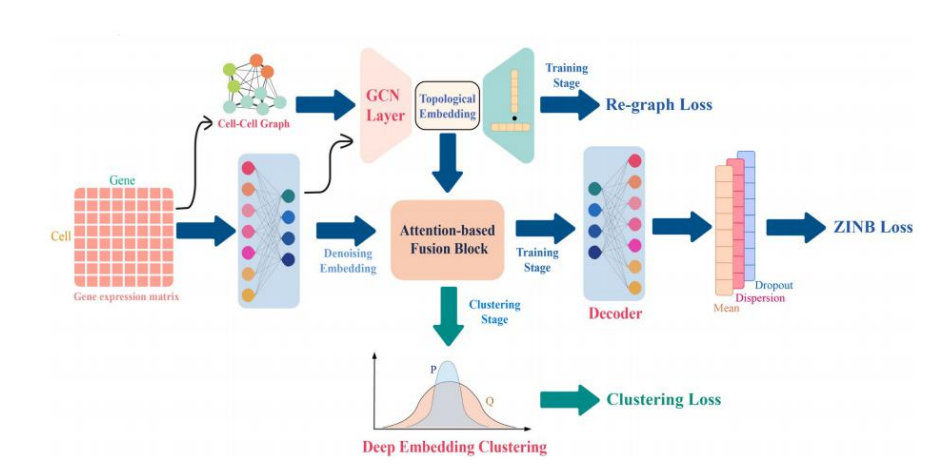


### 导入所需的库

In [2]:
import numpy as np
from scipy.special import digamma
import torch
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function, Variable
import torch.nn as nn
import torch.nn.functional as F
import anndata as ad
import scanpy
from collections import Counter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, davies_bouldin_score
import torch.optim.lr_scheduler as lr_scheduler
import time
from warnings import simplefilter
from sklearn import preprocessing
import pandas as pd

random.seed(1)

_epsilon = 1e-6

### Zero-Inflated Negative Binomial

In [3]:
# 定义一个自定义的 PyTorch Dataset 类，用于处理包含输入和输出的数据
class DictTensorDataset(Dataset):
    def __init__(self, inputs, outputs):
        # 计算输入中各项的长度并获取唯一值
        inlens = np.unique(np.array([len(x) for x in inputs.values()]))

        # 将输入和输出转换为 PyTorch Tensor，并存储在类的属性中
        self.inputs = {k: torch.from_numpy(v)
                       if type(v).__name__ == 'ndarray' else v for k, v in inputs.items()}

        self.outputs = {k: torch.from_numpy(v)
                        if type(v).__name__ == 'ndarray' else v for k, v in outputs.items()}

        # 获取数据集的长度，假设所有输入的第一个维度相同
        self.length = inlens[0]

    # 获取给定索引(index)处的特定样本
    # 返回一个包含该样本的输入和输出张量的字典元组
    def __getitem__(self, index):
        # 从数据集中获取单个样本，以字典形式返回输入和输出
        return ({k: v[index] for k, v in self.inputs.items()},
                {k: v[index] for k, v in self.outputs.items()})

    def __len__(self):
        # 返回数据集的总长度
        return self.length

    def type(self, dtype):
        # 将数据集中的所有 Tensor 转换为指定的数据类型
        return DictTensorDataset({k: v.type(dtype) for k, v in self.inputs.items()},
                                 {k: v.type(dtype) for k, v in self.outputs.items()})

    def cuda(self):
        # 将数据集中的所有 Tensor 移到 GPU 上
        return DictTensorDataset({k: v.cuda() for k, v in self.inputs.items()},
                                 {k: v.cuda() for k, v in self.outputs.items()})

    def float(self):
        # 将数据集中的所有 Tensor 转换为 float 类型
        return DictTensorDataset({k: v.float() for k, v in self.inputs.items()},
                                 {k: v.float() for k, v in self.outputs.items()})

    def double(self):
        # 将数据集中的所有 Tensor 转换为 double 类型
        return DictTensorDataset({k: v.double() for k, v in self.inputs.items()},
                                 {k: v.double() for k, v in self.outputs.items()})


# 定义一个简单的 PyTorch 模块，实现指数函数，并在 forward 方法中使用 clamp 方法
class ExpModule(torch.nn.Module):
    def __init__(self, eps=1e6):
        super().__init__()
        # 设置模块的属性，表示 clamp 方法中的上限值
        self.eps = eps

    # 前向传播
    # 接受一个输入张量x
    # 将输入张量x传递给torch.exp函数，该函数计算输入张量的指数
    # 使用clamp方法限制指数结果的最大值为self.eps。clamp函数可以确保指数结果不超过设定的最大值。
    # 返回经过指数和限制的张量作为前向传播的输出。
    def forward(self, x):
        # 在 forward 方法中使用指数函数和 clamp 方法处理输入张量
        return torch.exp(x).clamp(max=self.eps)


在样本基因表达过程中，方差一般大于均值，且随着均值表达量的上升，方差与均值的差异也越来越大，这并不符合泊松分布当中方差与均值相等的基本特征，这些数据的拟合模型偏向于负二项分布。

负二项分布描述的是伯努利实验，它的目标事件是对于Bernoulli过程设定，当某个结果出现固定次数的时候，整个过程的数量。公式如下：

$$
 P(X=k) = \binom{k+r-1}{k} p^k (1-p)^r 
$$

负二项分布的均值和方差分别为：

$$
\mu = \frac{pr}{1-p}
$$

$$
 \sigma^2 = \frac{pr}{(1-p)^2} 
$$

损失函数为

$$
\text{Loss}(mean, target, \theta) = -\psi(target + \theta) + \psi(\theta) - \psi(target + 1) - \theta \log(\theta) - \text{target} \log(\text{mean}) + (\theta + \text{target}) \log(\theta + \text{mean})
$$

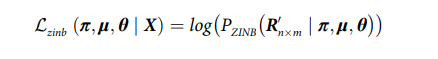

In [4]:
# 计算对数伽玛函数的前向传播和反向传播
class Lgamma(Function):
    # 前向传播
    # 接受一个输入张量input
    # torch.lgamma计算输入张量的对数伽玛函数值。
    # self.save_for_backward(input)将输入张量保存起来，以便在反向传播时使用。
    # 返回对数伽玛函数值作为前向传播的输出   
    @staticmethod
    def forward(self, input):
        # 保存输入张量，以便在反向传播时使用
        self.save_for_backward(input)
        # 返回 lgamma 函数的结果
        return torch.lgamma(input)

    # 反向传播
    # 接受一个梯度输出张量grad_output
    # self.saved_tensors获取保存的输入张量。
    # digamma函数计算输入张量的对数伽玛函数的导数（digamma函数）。
    # Variable(torch.from_numpy(...).type_as(input))将计算得到的导数转换为PyTorch张量，并与输入张量保持相同的数据类型和设备。
    # 返回梯度输出乘以对数伽玛函数导数的结果。
    @staticmethod
    def backward(self, grad_output):
        # 从保存的张量中获取输入
        input, = self.saved_tensors
        # 使用 digamma 函数计算 lgamma 函数的梯度
        res = Variable(torch.from_numpy(digamma(input.cpu().numpy())).type_as(input))
        # 返回梯度乘以计算得到的结果
        return grad_output * res


# 通过Lgamma.apply创建lgamma对象
lgamma = Lgamma.apply
 
# 损失函数，用于负二项分布（Negative Binomial Distribution）的损失计算    
class NBLoss(torch.nn.Module):
    def __init__(self, theta_shape=None, theta_dtype=torch.Tensor):
        super().__init__()

        # 如果提供了 theta_shape，则创建一个log-normal分布的参数theta，并将其注册为模型的可学习参数
        if theta_shape is not None:
            theta = torch.Tensor(*theta_shape).log_normal_(0.1, 0.01).type(theta_dtype)
            self.register_parameter('theta', torch.nn.Parameter(theta))

    # 前向传播
    # 使用输入的mean、target和计算得到的theta计算负二项分布损失的各个部分。
    # 将所有部分相加并取平均，最终得到损失值。
    def forward(self, mean, target, theta=None):
        eps = _epsilon

        # 如果没有提供 theta，则使用模块的参数 theta
        if theta is None:
            theta = 1.0 / (torch.exp(self.theta).clamp(max=1e7) + eps)

        # 计算负二项分布的损失函数
        t1 = -lgamma(target + theta + eps)
        t2 = lgamma(theta + eps)
        t3 = lgamma(target + 1.0)
        t4 = -(theta * (torch.log(theta + eps)))
        t5 = -(target * (torch.log(mean + eps)))
        t6 = (theta + target) * torch.log(theta + mean + eps)

        res = t1 + t2 + t3 + t4 + t5 + t6
        return res.mean()


# 实现零膨胀负二项分布的损失函数
class ZINBLoss(torch.nn.Module):
    # pi_ridge是一个用于正则化pi的项
    def __init__(self, theta_shape=None, pi_ridge=0.0):
        super().__init__()
        self.pi_ridge = pi_ridge

        # 如果theta_shape不为None，则创建一个log-normal分布的参数theta，将其注册为模型的可学习参数。
        if theta_shape is not None:
            theta = torch.Tensor(*theta_shape).log_normal_(0.1, 0.01)
            self.register_parameter('theta', torch.nn.Parameter(theta))

    def forward(self, mean, pi, target, theta=None):
        eps = _epsilon

        # 如果没有提供 theta，则使用模块的参数 theta
        if theta is None:
            theta = 1.0 / (torch.exp(self.theta).clamp(max=1e6) + eps)

        # reuse existing NB nll
        # 计算负二项分布的对数似然，减去零膨胀的对数概率
        nb_case = self.nb(mean, target, theta) - torch.log(1.0 - pi + eps)

         # 计算负二项分布在零值处的概率
        zero_nb = torch.pow(theta / (theta + mean + eps), theta)

         # 计算在零膨胀情况下的对数概率
        zero_case = -torch.log(pi + ((1.0 - pi) * zero_nb) + eps)

        # 创建一个与 target 相同类型的零膨胀的掩码。在这个掩码中，零值对应的位置为1，非零值对应的位置为0
        zero_mask = (target == 0.0).type_as(zero_case)
        
        # 创建一个与 zero_mask 相反的掩码，用于表示非零值的位置
        nb_mask = 1.0 - zero_mask

        # 最终的损失
        result = zero_mask * zero_case + nb_mask * nb_case

        if self.pi_ridge:
            ridge = self.pi_ridge * pi.pow(2)
            result += ridge# 应用正则化项

        return result.mean()
    
    def nb(self, input, target, theta):
        eps = _epsilon
        
        # 负二项分布的损失计算
        t1 = -lgamma(target + theta + eps)
        t2 = lgamma(theta + eps)
        t3 = lgamma(target + 1.0)
        t4 = -(theta * (torch.log(theta + eps)))
        t5 = -(target * (torch.log(input + eps)))
        t6 = (theta + target) * torch.log(theta + input + eps)

        res = t1 + t2 + t3 + t4 + t5 + t6
        return res


scRNA-seq数据的零值非常多，基因表达数据中的零值既可能来自生物过程中不表达的基因（True Zero），还可能来自测序过程中由于技术原因导致的丢失（False Zero 或者Dropout Zero），因此尝试在NB模型中加入一个零膨胀因子，用零膨胀负二项分布（Zero-Inflated Negative Binomial）来建模scRNA-seq数据

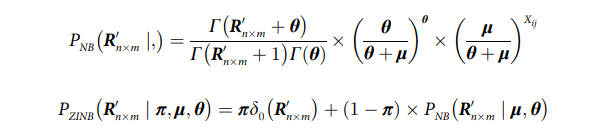



<!-- 
$$
\text{Loss}(mean, \pi, target, \theta) = \text{NB}(mean, target, \theta) - \log(1.0 - \pi + \epsilon) + \pi_{\text{ridge}} \cdot \pi^2
$$

$\pi_{\text{ridge}}$是用于正则化π的项，π 是零膨胀的概率 -->

In [5]:
# 自定义 PyTorch Module 类，实现零膨胀负二项分布的损失函数
class ZINBEMLoss(torch.nn.Module):
    def __init__(self, theta_shape=None, pi_ridge=0.0):
        super().__init__()
        self.pi_ridge = pi_ridge

        # 如果提供了 theta_shape，则初始化参数 theta
        if theta_shape is not None:
            theta = torch.Tensor(*theta_shape).log_normal_(0.1, 0.01)
            self.register_parameter('theta', torch.nn.Parameter(theta))

    def forward(self, mean, pi, target, zero_memberships, theta=None):
        eps = _epsilon

        # 如果没有提供 theta，则使用模块的参数 theta
        if theta is None:
            theta = 1.0 / (torch.exp(self.theta).clamp(max=1e6) + eps)

        # 计算零膨胀负二项分布的损失函数
        nb_memberships = 1.0 - zero_memberships

        zero_comp = pi.clone()
        zero_comp.masked_fill_(target != 0.0, 0.0)
        zero_comp = zero_memberships * torch.log(zero_comp + eps)

        nb_comp = torch.log(1.0 - pi + eps) - self.nb(mean, target, theta)
        nb_comp = nb_memberships * nb_comp

        result = -(zero_comp + nb_comp)

        if self.pi_ridge:
            ridge = self.pi_ridge * pi.pow(2)
            result += ridge

        return result.mean()

    def nb(self, input, target, theta):
        eps = _epsilon

        t1 = -lgamma(target + theta + eps)
        t2 = lgamma(theta + eps)
        t3 = lgamma(target + 1.0)
        t4 = -(theta * (torch.log(theta + eps)))
        t5 = -(target * (torch.log(input + eps)))
        t6 = (theta + target) * torch.log(theta + input + eps)

        res = t1 + t2 + t3 + t4 + t5 + t6
        return res

    def zero_memberships(self, mean, pi, target, theta=None):
        eps = _epsilon

        # 如果没有提供 theta，则使用模块的参数 theta
        if theta is None:
            theta = 1.0 / (torch.exp(self.theta).clamp(max=1e6) + eps)

        # 计算零膨胀负二项分布的零成员权重
        nb_zero_ll = torch.pow((theta / (theta + mean + eps)), theta)

        memberships = pi.clone()
        memberships = memberships / (memberships + ((1.0 - pi) * nb_zero_ll) + eps)
        memberships.masked_fill_(target != 0.0, 0.0)

        return memberships


首先将输入数据和模型参数转换为PyTorch Dataset，并根据用户指定的数据类型进行数据类型调整。随后，根据是否有验证集以及验证集划分比例进行相应的数据处理。在每个训练轮次中，通过遍历训练集的DataLoader，计算模型的预测值，损失函数的值，并进行反向传播更新模型参数。
函数还提供了可选的梯度裁剪和早停机制，用于防止梯度爆炸和提前停止训练。学习率调度器可根据验证损失或训练损失动态调整学习率。

In [6]:
def train(model_dict, loss_dict, model, loss, optimizer, epochs=1,
          val_split=0.1, val_data=None, batch_size=32, grad_clip=5.0,
          shuffle=True, verbose=0, early_stopping=None, scheduler=None,
          dtype='float'):
    # 创建自定义数据集
    dataset = DictTensorDataset(model_dict, loss_dict)

    # 根据 dtype 转换数据集、模型和损失函数的数据类型
    if dtype == 'cuda':
        dataset = dataset.float().cuda()
        model = model.float().cuda()
        loss = loss.float().cuda()
    elif dtype == 'double':
        dataset = dataset.double()
        model = model.double()
        loss = loss.double()
    elif dtype == 'float':
        dataset = dataset.float()
        model = model.float()
        loss = loss.float()
    else:
        raise ValueError('Unknown dtype')

    # 如果需要，对数据集进行随机重排
    if shuffle:
        idx = torch.randperm(len(dataset))
        if dtype == 'cuda':
            idx = idx.cuda()
        dataset = DictTensorDataset(*dataset[idx])

    # 划分训练集和验证集
    if val_data is not None:
        train_data = dataset
        val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
    elif val_split > 0.:
        off = int(len(dataset) * (1.0 - val_split))
        train_data = DictTensorDataset(*dataset[:off])
        val_data = DictTensorDataset(*dataset[off:])
        val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
    else:
        train_data, val_data = dataset, None

    loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    result = {'loss': [], 'model': model, 'early_stop': False}

    # 迭代训练过程
    if verbose:
        it = trange(epochs)
    else:
        it = range(epochs)

    for epoch in it:
        train_batch_losses = []

        for modeld, lossd in loader:
            cur_batch_size = len(lossd['target'])
            modeld = {k: Variable(v) for k, v in modeld.items()}
            lossd = {k: Variable(v) for k, v in lossd.items()}

            def closure():
                optimizer.zero_grad()
                pred = model(**modeld)
                if not isinstance(pred, dict): pred = {'input': pred}
                l = loss(**pred, **lossd)
                train_batch_losses.append(l.data.cpu().numpy()[0] * cur_batch_size)
                l.backward()
                if grad_clip:
                    for pg in optimizer.param_groups:
                        torch.nn.utils.clip_grad_norm(pg['params'], grad_clip)
                return l

            optimizer.step(closure)

        result['loss'].append(np.array(train_batch_losses).sum() / len(train_data))

        # 如果有验证集，计算验证集上的损失
        if val_data:
            for modeld, lossd in val_loader:
                modeld = {k: Variable(v) for k, v in modeld.items()}
                lossd = {k: Variable(v) for k, v in lossd.items()}
                model.eval()
                pred = model(**modeld)
                if not isinstance(pred, dict): pred = {'input': pred}
                l = loss(**pred, **lossd)
                model.train()
                result.setdefault('val_loss', []).append(l.data.cpu().numpy()[0])

        # 打印训练信息
        if verbose:
            text = 'Epoch: %s training loss: %s val loss: %s' % ((epoch + 1), result['loss'][-1],
                                                                 result['val_loss'][
                                                                     -1] if 'val_loss' in result else '---')
            print(text)

        # 调整学习率
        if scheduler:
            if val_data is not None:
                scheduler.step(result['val_loss'][-1])
            else:
                if epoch == 0 and scheduler.verbose:
                    print('Validation data not specified, using training loss for lr scheduling')
                scheduler.step(result['loss'][-1])

        # 提前停止训练
        if early_stopping and not early_stopping.step(result):
            result['early_stop'] = True
            return result

    return result



将输入进行指数变换，并通过clamp函数限制在特定范围，用于激活均值参数

$$MeanAct:f(x)=clamp(exp(x),1e−5,1e4)$$

通过softplus函数对输入进行变换，并通过clamp函数将输出限制在指定范围，用于激活离散度参数（方差）

$$DispAct:f(x)=clamp(softplus(x),1e−4,1e3)$$

softplus(⋅)是软加号函数，为$$log(1+epx())$$

Sigmoid函数将输入映射到范围 (0, 1)，常用于二分类问题，输出可以被解释为概率

$$PiAct:f(x)=1/(1+epx(-x))$$


In [7]:
# 创建一个匿名函数 MeanAct，用于计算均值的激活函数
MeanAct = lambda x: torch.clamp(torch.exp(x), 1e-5, 1e4)

# 创建一个匿名函数 DispAct，用于计算方差的激活函数
DispAct = lambda x: torch.clamp(F.softplus(x), 1e-4, 1e3)

# 创建一个匿名函数 PiAct，用于计算概率的激活函数
PiAct = lambda x: 1 / (1 + torch.exp(-1 * x))


###  Graph autoencoder

CNN只能在欧几里得数据(Euclideandata)，比如二维图片和一维文本数据上进行处理，而这些数据只是图结构的特例而已，对于一般的图结构，则很难使用.而图嵌入常⻅模型有DeepWalk，Node2Vec等，然而，这些方法方法有两种严重的缺点，首先就是节点编码中权重未共享，导致权重数量随着节点增多而线性增大，另外就是直接嵌入方法缺乏泛化能力，意味着无法处理动态图以及泛化到新的图。

基于以上原因，提出了GCN。GCN是一种连接模型，通过网络中节点之间的信息传递的方式来获取图中的依存关系，GCN通过从节点任意深度的邻居来更新该节点状态，这个状态能够表示状态信息。

GCN具有以下优势：

- GCN采用在每个节点上分别传播(propagate)的方式进行学习，由此忽略了节点的顺序，相当于GNN的输出会随着输入的不同而不同；
- GCN 可以通过图形结构进行传播，而不是将其作为节点特征的一部分，通过邻居节点的加权求和来更新节点的隐藏状态
- GCNs能够有效地捕捉细胞之间的复杂拓扑结构，通过考虑邻接关系和节点特征手工构造在没有先验知识的情况下细胞间的拓扑信息，需要构建两种细胞图：细胞-基因图、细胞-细胞图。
- GCNs能够融合多种节点特征，例如基因表达数据、细胞表型信息等，以更全面地描述细胞。多层次的图卷积，GCNs可以逐步提取和整合不同尺度的特征，有助于发现细胞聚类中的隐藏模式。
- 图神经网络 (GNN) 通过传播相邻细胞特征和在全局细胞图中构建细胞-细胞关系，在学习单个细胞的低维表示方面显示出优势。具有不同类型节点和边的异构图已被广泛用于建模多关系知识图。它为学习底层细胞类型特定的生物网络提供了一个自然的表示框架。用于建模和整合异构关系的注意机制的最新发展使深度学习模型可以解释，并使细胞类型特异性生物网络的推断成为可能。


In [8]:
# 定义一个 GNNLayer 类，继承自 PyTorch 的 nn.Module
class GNNLayer(nn.Module):
    # 初始化函数，接受输入特征的维度和输出特征的维度作为参数
    def __init__(self, in_features, out_features):
        # 调用父类的初始化函数
        super(GNNLayer, self).__init__()
        # 将输入特征维度和输出特征维度保存为类的属性
        self.in_features = in_features
        self.out_features = out_features
        # 定义一个可学习的参数，即权重矩阵，初始化为 Xavier 均匀分布
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        torch.nn.init.xavier_uniform_(self.weight)

    # 前向传播函数，接受输入特征、邻接矩阵和是否使用激活函数作为参数
    def forward(self, features, adj, active=True):
        # 对输入特征和权重矩阵进行矩阵乘法得到支持信息
        support = torch.mm(features, self.weight)
        # 将邻接矩阵与支持信息相乘得到输出特征
        output = torch.mm(adj, support)
        # 如果 active 为 True，应用 tanh 激活函数
        if active:
            output = torch.tanh(output)
        # 返回输出特征
        return output


In [9]:
# 定义 dot_product_decode 函数，用于计算图的邻接矩阵的预测值
def dot_product_decode(Z):
    # 使用 sigmoid 函数对 Z 与其转置的矩阵乘积进行处理，得到邻接矩阵的预测值
    A_pred = torch.sigmoid(torch.matmul(Z, Z.t()))
    # 返回邻接矩阵的预测值
    return A_pred


高斯噪声也称为白噪声,是一种通过向输入数据添加均值为零和标准差($σ$)的正态分布随机值而产生的噪声，训练时在输入数据中加入高斯噪声，可以通过数据扩充提高模型的鲁棒性和泛化能力。

高斯噪声也可以在训练过程中添加到神经网络的权重中以提高其性能，这种技术称为 Dropout。

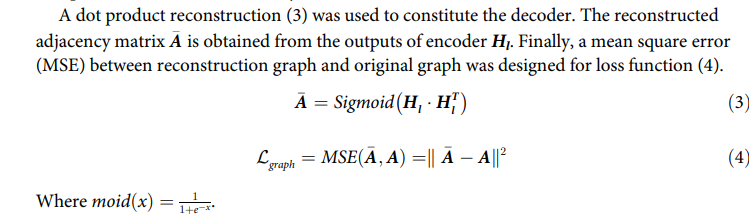

### Information fusion block

注意力机制如今已经被广泛地应用到了基于序列的任务中，它的优点是能够放大数据中最重要的部分的影响。这个特性已经被证明对许多任务有用，例如机器翻译和自然语言理解。如今融入注意力机制的模型数量正在持续增加，图神经网络也受益于此，它在聚合过程中使用注意力，整合多个模型的输出，并生成面向重要目标的随机行走。

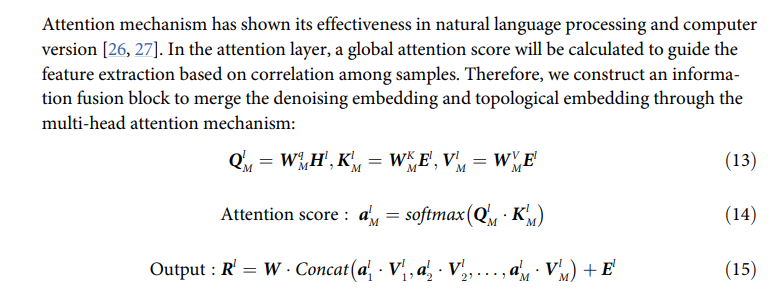

Transformer中，注意力模块会并行地重复计算多次。其中的每一次计算被称为一个注意力头（Attention Head）。注意力模块将其Query、Key和Value参数分成N份，然后将每一份独立地通过一个单独的Attention Head进行处理。所有这些Attention计算结果最终被融合在一起，形成最终的注意力分数。这被称为多头注意力，使得Transformer能够更好地捕捉每个单词之间的多重关系和细微差别。

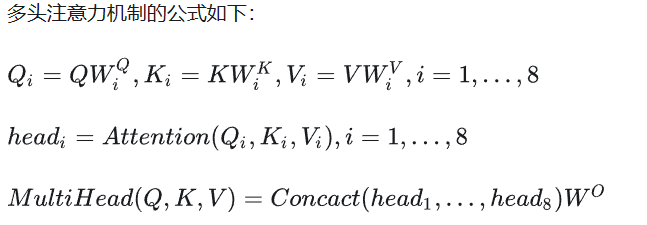

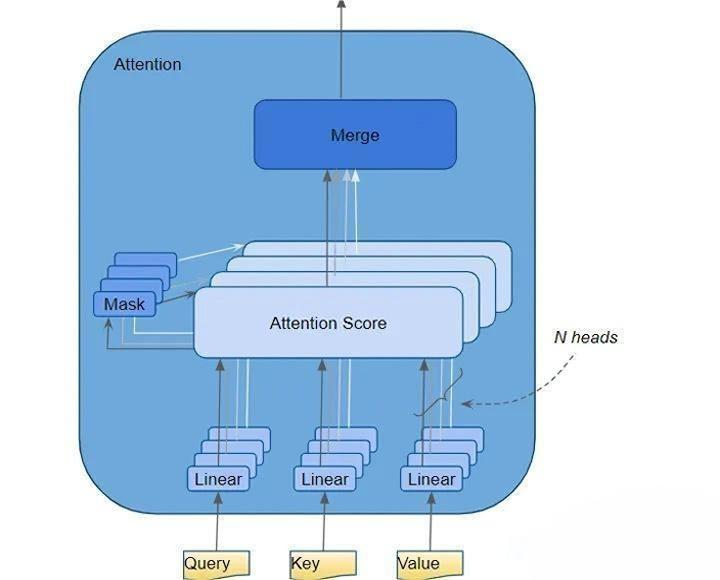

- 有三个独立的线性层，分别用于生成Query、Key和Value。每个线性层都有自己的权重。输入通过这些线性层，产生了 Q、K 和 V 矩阵。
- 接下来，数据被分割到多个注意力头中，以便每个头可以独立地进行处理。线性层的权重在逻辑上被按Attention Head分割，这种逻辑分割是通过在注Attention Head之间均匀分割输入数据以及线性层权重来实现的。Attention Head的计算可以通过单个矩阵乘法来实现，而不需要进行 N 个单独的矩阵乘法
- 线性层输出的Q、K 和 V 矩阵需要被变形，以包含一个显式的Attention Head维度。变形后，每个“切片”对应一个Attention Head。然后，该矩阵会通过调换Head和Seq维度被再次变形。

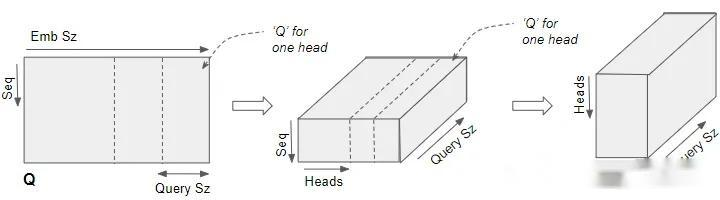

计算每个头的Attention Score，将每个Attention Head的注意力分数融合。

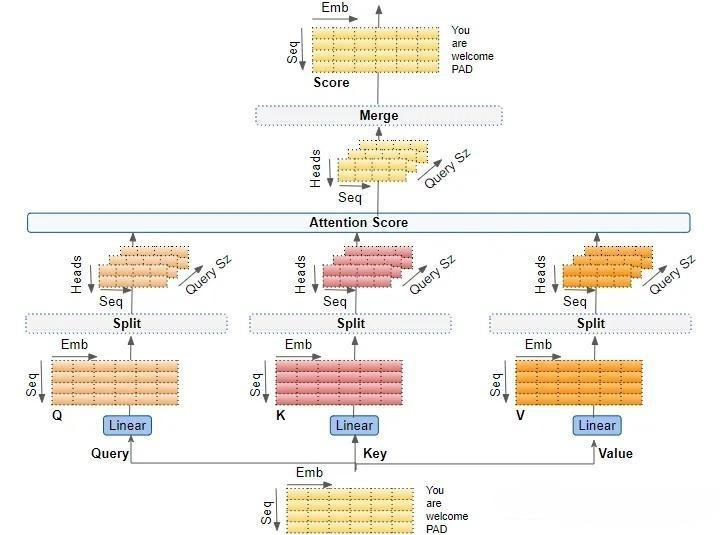

In [10]:
# 定义 GaussianNoise 类，用于添加高斯噪声到输入
class GaussianNoise(nn.Module):
    def __init__(self, device, sigma=1, is_relative_detach=True):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0, device=device)

    def forward(self, x):
        # 在训练模式且 sigma 不为零时，向输入 x 添加高斯噪声
        if self.training and self.sigma != 0:
            # 计算噪声的规模
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            # 生成噪声并与输入相加
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x
    # A multi-head attention layer has two different input (query and key/value).


# 定义 AttentionWide 类，实现多头注意力机制
class AttentionWide(nn.Module):
    def __init__(self, emb, p=0.2, heads=8, mask=False):
        super().__init__()

        self.emb = emb
        self.heads = heads
        self.dropout = nn.Dropout(p)
        # 定义线性变换层，用于将输入进行线性变换
        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        # 定义线性层，用于将多头注意力的输出进行线性变换并统一维度
        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x, y):
        b = 1
        t, e = x.size()
        h = self.heads

        # 对输入进行线性变换，得到 keys、queries 和 values
        keys = self.tokeys(x).view(b, t, h, e)
        queries = self.dropout(self.toqueries(y)).view(b, t, h, e)
        values = self.tovalues(x).view(b, t, h, e)

        # 折叠多头到 batch 维度
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        # 对 queries 和 keys 进行缩放
        queries = queries / (e ** (1 / 4))
        keys = keys / (e ** (1 / 4))

        # 计算点积注意力
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b * h, t, t)

        # 计算 softmax 得到注意力权重
        dot = F.softmax(dot, dim=2)
        self.attention_weights = dot
        # 使用注意力权重对 values 进行加权求和并重新整理维度
        out = torch.bmm(dot, values).view(b, h, t, e)
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        # 对多头注意力的输出进行线性变换并统一维度
        return self.unifyheads(out)



### Denoising  autoencoder

- 编码器部分包括两个线性层 enc_1 和 enc_2，Batch Normalization层 BN_1 和 BN_2，以及一个线性层 z_layer 用于生成隐变量；
- 解码器部分包括两个线性层 dec_1 和 dec_2；
- 用于计算概率分布的线性层 calcu_pi、calcu_mean 和 calcu_disp；
- 两个图神经网络（GNN）层 gnn_1 和 gnn_2；
- 两个自注意力层 attn1 和 attn2；
- 前向传播函数 forward中输入x和adj图的邻接矩阵；

编码器实现流程过下：
1. 在编码器过程中输入经过高斯噪声 Gnoise 和第一个线性层 enc_1，然后经过ReLU激活函数和Batch Normalization层 BN_1。经过图神经网络层 gnn_1，再经过第二个线性层 enc_2 和ReLU激活函数以及Batch Normalization层 BN_2。使用自注意力机制 attn1，通过线性层 z_layer 生成隐变量 z ，然后通过图神经网络层 gnn_2。
2. 在解码器过程中隐变量 z 经过解码器的两个线性层 dec_1 和 dec_2，然后通过线性层计算概率分布的参数：calcu_pi、calcu_mean 和 calcu_disp
3. 返回隐变量 z、重构的图 A_pred 以及计算得到的概率分布参数 pi、mean 和 disp。

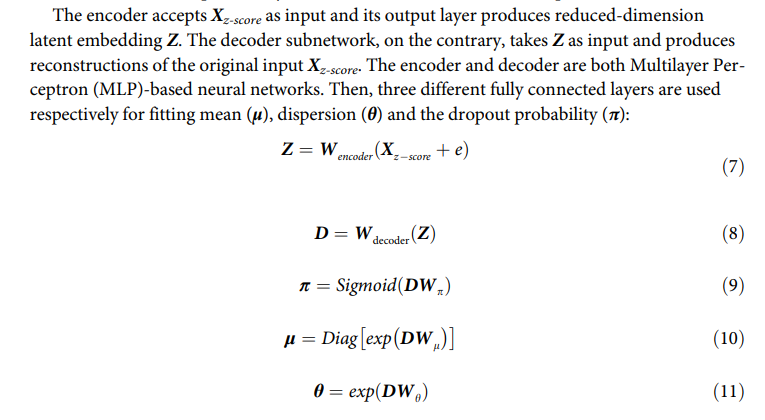

In [11]:
# 定义 AttentionAE 类，实现带有注意力机制的自编码器
class AttentionAE(nn.Module):
    def __init__(self, n_enc_1, n_enc_2, n_dec_1, n_dec_2,
                 n_input, n_z, heads, device):
        super(AttentionAE, self).__init__()

        # 定义高斯噪声模块
        self.Gnoise = GaussianNoise(sigma=0.1, device=device)

        # 定义编码器部分
        self.enc_1 = nn.Linear(n_input, n_enc_1)
        self.BN_1 = nn.BatchNorm1d(n_enc_1)
        self.enc_2 = nn.Linear(n_enc_1, n_enc_2)
        self.BN_2 = nn.BatchNorm1d(n_enc_2)
        self.z_layer = nn.Linear(n_enc_2, n_z)

        # 定义解码器部分
        self.dec_1 = nn.Linear(n_z, n_dec_1)
        self.dec_2 = nn.Linear(n_dec_1, n_dec_2)

        # 用于计算 pi、mean 和 disp 的线性层
        self.calcu_pi = nn.Linear(n_dec_2, n_input)
        self.calcu_disp = nn.Linear(n_dec_2, n_input)
        self.calcu_mean = nn.Linear(n_dec_2, n_input)

        # 定义两层图神经网络
        self.gnn_1 = GNNLayer(n_enc_1, n_enc_2)
        self.gnn_2 = GNNLayer(n_enc_2, n_z)

        # 定义两个注意力层
        self.attn1 = AttentionWide(n_enc_2, heads=heads)
        self.attn2 = AttentionWide(n_z, heads=heads)

    def forward(self, x, adj):
        # 编码器部分
        enc_h1 = self.BN_1(F.relu(self.enc_1(self.Gnoise(x))))
        # enc_h1 = (self.attn1(enc_h1, h1)).squeeze(0) + enc_h1
        h1 = self.gnn_1(enc_h1, adj)
        h2 = self.gnn_2(h1, adj)
        enc_h2 = self.BN_2(F.relu(self.enc_2(self.Gnoise(enc_h1))))
        enc_h2 = (self.attn1(enc_h2, h1)).squeeze(0) + enc_h2
        z = self.z_layer(self.Gnoise(enc_h2))
        z = (self.attn2(z, h2)).squeeze(0) + z
        # decoder

        # 解码器部分
        A_pred = dot_product_decode(h2)
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))

        # 计算 pi、mean 和 disp
        pi = PiAct(self.calcu_pi(dec_h2))
        mean = MeanAct(self.calcu_mean(dec_h2))
        disp = DispAct(self.calcu_disp(dec_h2))
        return z, A_pred, pi, mean, disp

该部分训练流程如下：

1. 定义优化器和学习率调度器
2. 在每个训练周期中，通过前向传播计算损失，包括负二项分布损失和重构图的均方误差
3. 如果损失减小，则更新模型为当前的最佳模型，然后进行梯度裁剪和梯度更新。
4. 最后返回最佳模型和训练时间。

在自定义的loss中，计算输入样本与聚类中心的距离，根据距离计算样本的权重和聚类中心的权重，然后使用KL散度计算损失。最后返回损失和样本分布。


In [12]:
def train(init_model, Zscore_data, rawData, adj, r_adj, size_factor, device, args):
    # 记录开始时间和初始GPU内存
    start_time = time.time()
    start_mem = torch.cuda.max_memory_allocated(device=device)

    # 将初始化模型移动到指定设备上
    init_model.to(device)
    
    # 转换数据为Tensor，并将size_factor转换为Variable
    data = torch.Tensor(Zscore_data).to(device)
    sf = torch.autograd.Variable(torch.from_numpy(size_factor[:, None]).type(torch.FloatTensor).to(device),
                                 requires_grad=True)
    
    # 定义优化器和学习率调度器
    optimizer = torch.optim.Adam(init_model.parameters(), lr=args.lr)
    adj = torch.Tensor(adj).to(device)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5, last_epoch=-1)
    
    best_model = init_model
    loss_update = 100000
    
    # 训练循环
    for epoch in range(args.training_epoch):
        # 前向传播
        z, A_pred, pi, mean, disp = init_model(data, adj)
        
        # 计算ZINB损失和重构图损失
        l = ZINBLoss(theta_shape=(args.n_input,))
        zinb_loss = l(mean * sf, pi, target=torch.tensor(rawData).to(device), theta=disp)
        re_graphloss = torch.nn.functional.mse_loss(A_pred.view(-1), torch.Tensor(r_adj).to(device).view(-1))
        loss = zinb_loss + 0.1 * re_graphloss

        # 每10个epoch打印一次损失
        if (epoch + 1) % 10 == 0:
            print("epoch %d, loss %.4f, zinb_loss %.4f, re_graphloss %.4f"
                  % (epoch + 1, loss, zinb_loss, re_graphloss))

        # 更新最小损失和对应的模型
        if loss_update > loss:
            loss_update = loss
            best_model = init_model
            epoch_update = epoch
        
    
        # 梯度清零，反向传播，梯度裁剪，优化器更新
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(init_model.parameters(), max_norm=3, norm_type=2)
        optimizer.step()
        scheduler.step()
    
    # 训练结束，计算时间和最终GPU内存
    elapsed_time = time.time() - start_time
    max_mem = torch.cuda.max_memory_allocated(device=device) - start_mem
    print("Finish Training! Elapsed time: {:.4f} seconds, Max memory usage: {:.4f} MB".format(elapsed_time,
                                                                                              max_mem / 1024 / 1024))
    return best_model, elapsed_time


# 定义超参数 alpha
alpha = 1


def loss_func(z, cluster_layer):
    # 计算q分布
    q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - cluster_layer) ** 2, dim=2) / alpha)
    q = q ** (alpha + 1.0) / 2.0
    q = (q.t() / torch.sum(q, dim=1)).t()

    # 计算p分布
    weight = q ** 2 / torch.sum(q, dim=0)
    p = (weight.t() / torch.sum(weight, dim=1)).t()

    # 计算KL散度损失
    log_q = torch.log(q)
    loss = torch.nn.functional.kl_div(log_q, p, reduction='batchmean')
    return loss, p


### Deep embedding clustering

下述两函数一起用于在细胞数据上进行聚类和构建细胞-细胞图：

- 聚类函数中利用预训练模型pretrain_model获取隐变量 z。
- 利用 z 进行Leiden聚类，得到聚类中心和初始标签。
- 计算初始的ASW（轮廓系数）。
- 定义优化器，包括预训练模型的参数和聚类中心作为可学习参数。
- 在每个聚类周期中，通过前向传播计算损失，包括KL散度损失、负二项分布损失和重构图的均方误差。
- 输出损失和聚类相关的信息。
- 训练模型并更新聚类中心。
- 返回初始标签、聚类中心、训练后的模型和训练时间。


adata_knn构建细胞-细胞图:
- adata: AnnData对象，包含细胞数据；
- method: 邻域构建方法，可以是'umap'或'gauss'；
- knn: 是否使用knn近邻法；
- n_neighbors: 近邻数量；
- metric: 距离度量。
    
如果细胞数量较多，进行PCA降维，利用指定的方法构建细胞之间的邻接关系，最终返回构建的图的邻接矩阵和距离矩阵。

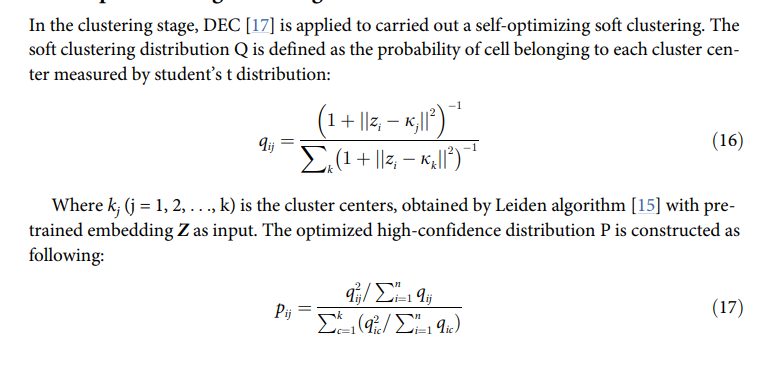

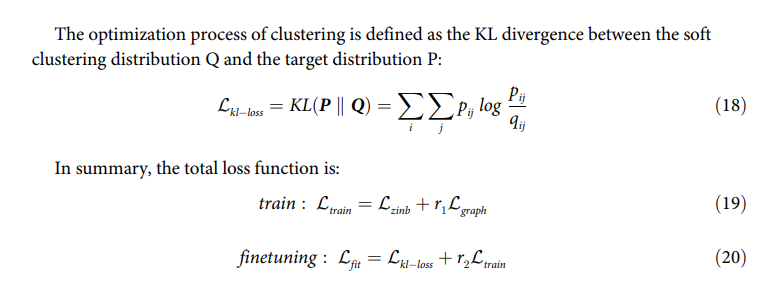

In [13]:
def clustering(pretrain_model, Zscore_data, rawData, celltype, adj, r_adj, size_factor, device, args):
    # 记录开始时间和初始GPU内存
    start_time = time.time()
    start_mem = torch.cuda.max_memory_allocated(device=device)

    # 转换数据为Tensor，并将size_factor转换为Variable
    data = torch.Tensor(Zscore_data).to(device)
    adj = torch.Tensor(adj).to(device)
    model = pretrain_model.to(device)
    sf = torch.autograd.Variable(torch.from_numpy(size_factor[:, None]).type(torch.FloatTensor).to(device),
                                 requires_grad=True)
    
    # 获取预训练模型的隐藏表示
    with torch.no_grad():
        z, _, _, _, _ = model(data, adj)

    # 使用Leiden算法进行初始聚类
    cluster_centers, init_label = use_Leiden(z.detach().cpu().numpy(), resolution=args.resolution)
    cluster_layer = torch.autograd.Variable(torch.from_numpy(cluster_centers).type(torch.FloatTensor).to(device),
                                            requires_grad=True)
    
    # 计算初始聚类的评估指标ASW
    asw = np.round(silhouette_score(z.detach().cpu().numpy(), init_label), 3)

    # 如果提供了真实标签，计算ARI和NMI
    if celltype is not None:
        nmi = np.round(normalized_mutual_info_score(celltype, init_label), 3)
        ari = np.round(adjusted_rand_score(celltype, init_label), 3)
        print('init: ASW= %.3f, ARI= %.3f, NMI= %.3f' % (asw, ari, nmi))
    else:
        print('init: ASW= %.3f' % (asw))
    elapsed_time = time.time() - start_time

    # 定义优化器，包括对聚类中心的学习率
    optimizer = torch.optim.Adam(list(model.enc_1.parameters()) + list(model.enc_2.parameters()) +
                                 list(model.attn1.parameters()) + list(model.attn2.parameters()) +
                                 list(model.gnn_1.parameters()) + list(model.gnn_2.parameters()) +
                                 list(model.z_layer.parameters()) + [cluster_layer], lr=0.001)

    # 聚类迭代训练
    for epoch in range(args.clustering_epoch):
        z, A_pred, pi, mean, disp = model(data, adj)
        kl_loss, ae_p = loss_func(z, cluster_layer)
        l = ZINBLoss(theta_shape=(args.n_input,))
        zinb_loss = l(mean * sf, pi, target=torch.tensor(rawData).to(device), theta=disp)
        re_graphloss = torch.nn.functional.mse_loss(A_pred.view(-1), torch.Tensor(r_adj).to(device).view(-1))
        loss = kl_loss + 0.1 * zinb_loss + 0.01 * re_graphloss
        loss.requires_grad_(True)
        label = dist_2_label(ae_p)

        # 计算聚类效果指标ASW和DB
        asw = silhouette_score(z.detach().cpu().numpy(), label)
        db = davies_bouldin_score(z.detach().cpu().numpy(), label)
        # ari = adjusted_rand_score(celltype, label)
        # nmi = normalized_mutual_info_score(celltype, label)

        # 每10个epoch打印一次损失和ASW
        if (epoch + 1) % 10 == 0:
            print("epoch %d, loss %.4f, kl_loss %.4f, ASW %.3f" % (epoch + 1, loss, kl_loss, asw))
        
        # 如果达到停止条件，则提前结束训练
        num = data.shape[0]
        tol = 1e-3
        if epoch == 0:
            last_label = label
        else:
            delta_label = np.sum(label != last_label).astype(np.float32) / num
            last_label = label
            if epoch > 20 and delta_label < tol:
                print('delta_label ', delta_label, '< tol ', tol)
                print("Reach tolerance threshold. Stopping training.")
                elapsed_time = time.time() - start_time
                max_mem = torch.cuda.max_memory_allocated(device=device) - start_mem
                print("Elapsed time: {:.4f} seconds, Max memory usage: {:.4f} MB".format(elapsed_time,
                                                                                         max_mem / 1024 / 1024))
                break
        # 梯度清零，反向传播，梯度裁剪，优化器更新
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3, norm_type=2)
        optimizer.step()

    # 训练结束，计算时间和最终GPU内存
    max_mem = torch.cuda.max_memory_allocated(device=device) - start_mem
    print("Finish Clustering! Elapsed time: {:.4f} seconds, Max memory usage: {:.4f} MB".format(elapsed_time,
                                                                                                max_mem / 1024 / 1024))

    return init_label, cluster_layer, model, elapsed_time



# constructing the cell-cell graph
# 构建细胞-细胞图
def adata_knn(adata, method, knn, n_neighbors, metric='cosine'):
    if adata.shape[0] >= 10000:
        scanpy.pp.pca(adata, n_comps=50)
        n_pcs = 50
    else:
        n_pcs = 0
    if method == 'umap':
        scanpy.pp.neighbors(adata, method=method, metric=metric,
                            knn=knn, n_pcs=n_pcs, n_neighbors=n_neighbors)
        r_adj = adata.obsp['distances']
        adj = adata.obsp['connectivities']
    elif method == 'gauss':
        scanpy.pp.neighbors(adata, method='gauss', metric=metric,
                            knn=knn, n_pcs=n_pcs, n_neighbors=n_neighbors)
        r_adj = adata.obsp['distances']
        adj = adata.obsp['connectivities']
    return adj, r_adj


load_data读取表达数据，并进行数据过滤、规范化等预处理。使用scanpy.pp.highly_variable_genes筛选高度可变的基因，保留前2500个高度可变基因，adata = adata[:, adata.var['highly_variable']]保留筛选后的高度可变基因。

调用adata_knn函数构建基因表达数据的邻接图（Connectivity graph），该图用于后续的图神经网络 (GNN) 训练

use_Leiden 函数使用 Leiden 算法来初始化聚类中心。 

构建邻居图，使用Leiden算法进行聚类，获取 Leiden 算法的聚类结果，得到一个包含每个细胞所属聚类的数组 Y_pred_init，将特征矩阵和Leiden聚类结果整理在一起，计算每个聚类的平均值得到聚类中心。

random_downsimpling 函数用于对数据进行随机下采样，以减少数据规模。计算下采样比例 p，并按细胞类型和索引排序。

对每个细胞类型的样本，随机选择其中的一部分样本进行下采样。采样数量由 int(j * p) 决定，其中 j 是每个细胞类型的样本总数。将下采样的结果以二进制形式表示，1 表示样本被选择，0 表示样本未被选择。将生成的二进制列添加到 DataFrame 中，然后对DataFrame进行索引排序。根据生成的采样标志列，提取相应索引的细胞数据，包括基因表达矩阵 new_X、观测信息 new_obs 和原始数据的基因表达矩阵 new_data_raw_X。

In [14]:
# 从数据文件中加载基因表达数据到 (pre-)train 函数中
def load_data(dataPath, args, metric='cosine', dropout=0, preprocessing_sc=True):
    # 读取数据文件
    adata = ad.read(dataPath + '.h5ad')
    # 过滤细胞和基因
    scanpy.pp.filter_cells(adata, min_genes=1)
    scanpy.pp.filter_genes(adata, min_cells=1)
    adata.raw = adata
    adata.X = adata.X.astype(np.float32)
    # 归一化和对数变换
    scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    scanpy.pp.log1p(adata)
    # 筛选高变基因
    scanpy.pp.highly_variable_genes(adata, n_top_genes=2500)
    adata.raw.var['highly_variable'] = adata.var['highly_variable']
    adata = adata[:, adata.var['highly_variable']]
    dataMat = adata.X
    rawData = adata.raw[:, adata.raw.var['highly_variable']].X

    # 构建图结构
    adj, r_adj = adata_knn(adata, method=args.connectivity_methods, knn=args.knn,
                           n_neighbors=args.n_neighbors, metric=metric)
    return adata, rawData, dataMat, adj, r_adj


# 使用Leiden算法初始化聚类中心
def use_Leiden(features, resolution=1):
    adata0 = scanpy.AnnData(features)
    scanpy.pp.neighbors(adata0, knn=False, method='gauss', metric='cosine', n_pcs=0)
    scanpy.tl.leiden(adata0, resolution=resolution)
    Y_pred_init = adata0.obs['leiden']
    init_pred = np.asarray(Y_pred_init, dtype=int)
    features = pd.DataFrame(adata0.X, index=np.arange(0, adata0.shape[0]))
    Group = pd.Series(init_pred, index=np.arange(0, adata0.shape[0]), name="Group")
    Mergefeature = pd.concat([features, Group], axis=1)
    cluster_centers = np.asarray(Mergefeature.groupby("Group").mean())
    return cluster_centers, init_pred


# 随机下采样
def random_downsimpling(data, num_cell):
    
    p = num_cell / data.shape[0]
    matrix = pd.DataFrame([np.array(range(data.shape[0])), data.obs['cell_type']]).transpose()
    matrix.columns = ['index', 'celltype']
    sort_matrix = matrix.sort_values(['celltype', 'index'])
    t_sample = []
    groups = Counter(sort_matrix['celltype'])
    for j in groups.values():
        sample = []
        sub_sample = random.sample(range(j), int(j * p))
        for k in range(j):
            if k in sub_sample:
                sample.append(1)
            else:
                sample.append(0)
        t_sample += sample
    sort_matrix['sampling'] = np.array(t_sample, dtype=np.bool8)
    final_sort_matrix = sort_matrix.sort_values(['index'])
    sample = []
    for i in range(data.shape[0]):
        if final_sort_matrix['sampling'][i]:
            sample.append(i)
    new_X = data.X[sample, :]
    new_obs = data.obs.iloc[sample, :]
    new_data_raw_X = data.raw.X[sample, :]
    new_data = ad.AnnData(X=new_X, obs=new_obs, var=data.var)
    new_data.raw = ad.AnnData(X=new_data_raw_X, obs=new_data.obs, var=data.raw.var)
    return new_data


# 获取预测的细胞标签
def dist_2_label(p):
    _, label = torch.max(p, dim=1)
    return label.data.cpu().numpy()

# UMAP可视化
def umap_visual(data, title=None, save_path=None, label=None, asw_used=None):
    reducer = umap.UMAP(random_state=4132231)
    embedding = reducer.fit_transform(data)
    n_lables = len(set(label)) + 1
    mean_silhouette_score = silhouette_score(data, label)
    xlim_l = int(embedding[:, 0].min()) - 2
    xlim_r = int(embedding[:, 0].max()) + 2
    ylim_d = int(embedding[:, 1].min()) - 2
    ylim_u = int(embedding[:, 1].max()) + 2
    plt.figure(figsize=(6, 4), dpi=200)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=label, cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(n_lables)).set_ticks(np.arange(n_lables))
    plt.xlim((xlim_l, xlim_r))
    plt.ylim((ylim_d, ylim_u))
    plt.title('UMAP projection of the {0}'.format(title))
    if asw_used is not None:
        plt.text(xlim_r - 2, ylim_d + 1.5, "ASW=%.3f" % (mean_silhouette_score),
                 ha="right", )
    plt.grid(False)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    plt.close()


对数据进行预处理之后，如果细胞数量小于等于设定的 max_num_cell，则直接进行模型训练和聚类；如果细胞数量大于 max_num_cell，则进行下采样，以适应模型的训练。下采样后，同样进行模型训练和聚类。

使用 AttentionAE 模型进行初始化，并在数据上进行训练，得到 pretrain_model。
使用 clustering 函数对数据进行聚类，得到聚类的标签 pred_label。

如果提供了已知的细胞类型信息 (celltype 参数为 "known")，则计算 Adjusted Rand Index (ARI)、Normalized Mutual Information (NMI)、Average Silhouette Width (ASW) 等评价指标。
打印或输出聚类结果的评价指标。

In [15]:
from random import sample
import warnings
warnings.filterwarnings("ignore")
class args:
    lr = 0.007
    n_z = 16
    n_heads = 8
    n_hvg = 5000
    training_epoch = 200
    clustering_epoch = 0
    resolution = 1.3
    connectivity_methods = 'gauss'
    n_neighbors = 15
    knn = False
    name = 'dataset1'
    celltype = None
    save_pred_label = False
    save_umap = True
    max_num_cell = 2000
    cuda = True
    nod1 = 256
    nod2 = 64


if __name__ == "__main__":
    args = args
    device = torch.device("cuda" if args.cuda else "cpu")
    simplefilter(action='ignore', category=FutureWarning)

    if args.save_umap is True:
        umap_save_path = ['./%s_pred_label.png' % (args.name),
                          './%s_true_label.png' % (args.name)]
    # else:
    umap_save_path = [None, None]

    adata, rawData, dataset, adj, r_adj = load_data('./{}'.format(args.name), args=args)

    if args.celltype == "known":
        celltype = adata.obs['cell_type'].tolist()
    else:
        celltype = None
        ct = np.random.choice(["B", "T", "A"], size=(adata.n_obs,))
        adata.obs["cell_type"] = pd.Categorical(ct) 
    new_adata = random_downsimpling(adata, args.max_num_cell)
    new_adj, new_r_adj = adata_knn(new_adata, method=args.connectivity_methods,
                                         knn=args.knn, n_neighbors=args.n_neighbors)
    try:
        new_Zscore_data = preprocessing.scale(new_adata.X.toarray())
        new_rawData = new_adata.raw[:, adata.raw.var['highly_variable']].X.toarray()
    except:
        new_Zscore_data = preprocessing.scale(new_adata.X)
        new_rawData = new_adata.raw[:, adata.raw.var['highly_variable']].X

    size_factor = new_adata.obs['size_factors'].values
    try:
        Zscore_data = preprocessing.scale(dataset.toarray())
    except:
        Zscore_data = preprocessing.scale(dataset)

    new_celltype = new_adata.obs['cell_type']
    args.n_input = dataset.shape[1]
    init_model = AttentionAE(args.nod1, args.nod2, args.nod2, args.nod1, n_input=args.n_input, n_z=args.n_z, heads=args.n_heads,
                             device=device)
    pretrain_model, train_elapsed_time = train(init_model, new_Zscore_data, new_rawData,
                                               new_adj, new_r_adj, size_factor, device, args)
    pred_label, cluster_layer, model, _ = clustering(pretrain_model, new_Zscore_data, new_rawData,
                                               new_celltype, new_adj, new_r_adj, size_factor, device, args)

    copy_model = AttentionAE(args.nod1, args.nod2, args.nod2, args.nod1, n_input=args.n_input, n_z=args.n_z, heads=args.n_heads,
                             device=torch.device('cpu'))
    copy_model.load_state_dict(model.state_dict())

    data = torch.Tensor(Zscore_data).cpu()
    adj = torch.Tensor(adj).cpu()
    with torch.no_grad():
        z, _, _, _, _ = copy_model(data, adj)
        if args.celltype == "known":
            ari = np.round(adjusted_rand_score(celltype, pred_label), 3)
            print("Final ARI %.3f" % ari)
        else:
            print("Final finished!")
    if args.save_pred_label is True:
        np.savetxt('./temp.csv', pred_label)

epoch 10, loss 0.2705, zinb_loss 0.2364, re_graphloss 0.3405
epoch 20, loss 0.2433, zinb_loss 0.2108, re_graphloss 0.3245
epoch 30, loss 0.2394, zinb_loss 0.2069, re_graphloss 0.3246
epoch 40, loss 0.2369, zinb_loss 0.2045, re_graphloss 0.3240
epoch 50, loss 0.2355, zinb_loss 0.2031, re_graphloss 0.3240
epoch 60, loss 0.2342, zinb_loss 0.2018, re_graphloss 0.3240
epoch 70, loss 0.2327, zinb_loss 0.2003, re_graphloss 0.3240
epoch 80, loss 0.2317, zinb_loss 0.1993, re_graphloss 0.3239
epoch 90, loss 0.2312, zinb_loss 0.1988, re_graphloss 0.3239
epoch 100, loss 0.2308, zinb_loss 0.1984, re_graphloss 0.3238
epoch 110, loss 0.2304, zinb_loss 0.1981, re_graphloss 0.3238
epoch 120, loss 0.2301, zinb_loss 0.1977, re_graphloss 0.3238
epoch 130, loss 0.2298, zinb_loss 0.1974, re_graphloss 0.3237
epoch 140, loss 0.2296, zinb_loss 0.1972, re_graphloss 0.3237
epoch 150, loss 0.2294, zinb_loss 0.1970, re_graphloss 0.3237
epoch 160, loss 0.2291, zinb_loss 0.1968, re_graphloss 0.3237
epoch 170, loss 0

epoch 10, loss 0.1108, zinb_loss 0.0940, re_graphloss 0.1679
epoch 20, loss 0.1017, zinb_loss 0.0849, re_graphloss 0.1678
epoch 30, loss 0.0996, zinb_loss 0.0829, re_graphloss 0.1671
epoch 40, loss 0.0985, zinb_loss 0.0818, re_graphloss 0.1671
epoch 50, loss 0.0979, zinb_loss 0.0812, re_graphloss 0.1670
epoch 60, loss 0.0975, zinb_loss 0.0809, re_graphloss 0.1668
epoch 70, loss 0.0969, zinb_loss 0.0802, re_graphloss 0.1667
epoch 80, loss 0.0962, zinb_loss 0.0795, re_graphloss 0.1667
epoch 90, loss 0.0958, zinb_loss 0.0791, re_graphloss 0.1667
epoch 100, loss 0.0955, zinb_loss 0.0789, re_graphloss 0.1667
epoch 110, loss 0.0952, zinb_loss 0.0785, re_graphloss 0.1666
epoch 120, loss 0.0949, zinb_loss 0.0782, re_graphloss 0.1665
epoch 130, loss 0.0946, zinb_loss 0.0780, re_graphloss 0.1664
epoch 140, loss 0.0945, zinb_loss 0.0779, re_graphloss 0.1664
epoch 150, loss 0.0943, zinb_loss 0.0777, re_graphloss 0.1664
epoch 160, loss 0.0942, zinb_loss 0.0775, re_graphloss 0.1664
epoch 170, loss 0

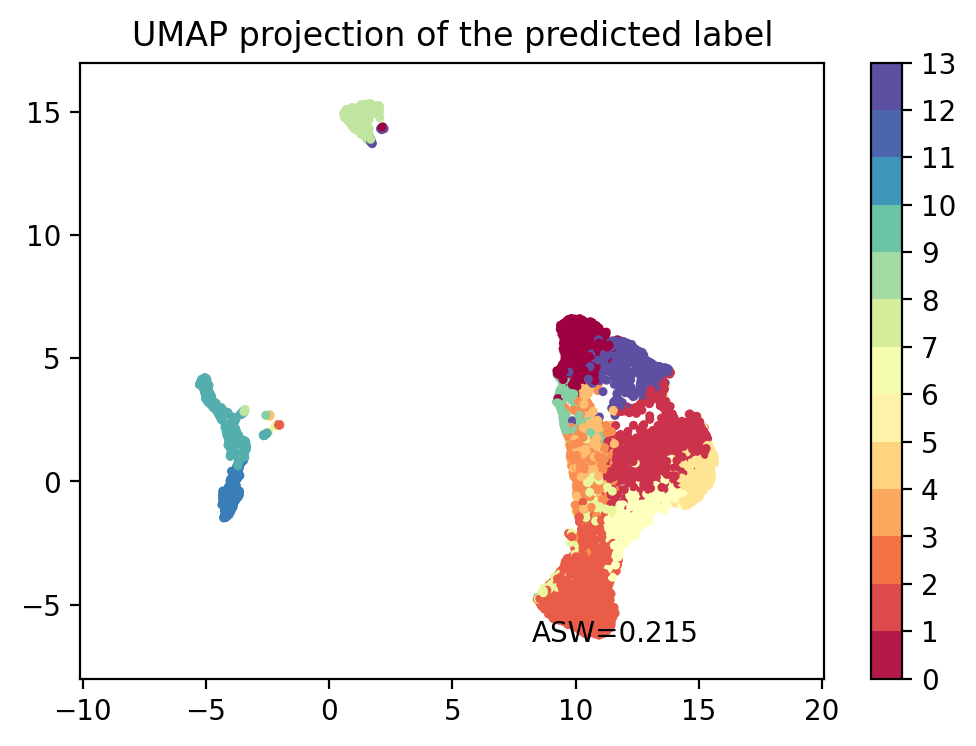

In [31]:
import warnings
warnings.filterwarnings("ignore")
class args:
    lr = 0.001
    n_z = 16
    n_heads = 8
    n_hvg = 5000
    training_epoch = 250
    clustering_epoch = 0
    resolution = 1.5
    connectivity_methods = 'gauss'
    n_neighbors = 15
    knn = False
    name = 'dataset2'
    celltype = 'known'
    save_pred_label = True
    # save_model_para = False
    # save_embedding = False
    save_umap = True
    max_num_cell = 2000
    cuda = True
    nod1 = 256
    nod2 = 64
    nod3 = 512
    nod4 = 128


if __name__ == "__main__":
    args = args
    device = torch.device("cuda" if args.cuda else "cpu")
    simplefilter(action='ignore', category=FutureWarning)

    if args.save_umap is True:
        umap_save_path = ['./%s_pred_label.png' % (args.name),
                          './%s_true_label.png' % (args.name)]
    # else:
    umap_save_path = [None, None]
    adata, rawData, dataset, adj, r_adj = load_data('./{}'.format(args.name), args=args)

    if args.celltype == "known":
        celltype = adata.obs['cell_type'].tolist()
    else:
        celltype = None

    new_adata = random_downsimpling(adata, args.max_num_cell)
    new_adj, new_r_adj = adata_knn(new_adata, method=args.connectivity_methods,
                                         knn=args.knn, n_neighbors=args.n_neighbors)
    try:
        new_Zscore_data = preprocessing.scale(new_adata.X.toarray())
        new_rawData = new_adata.raw[:, adata.raw.var['highly_variable']].X.toarray()
    except:
        new_Zscore_data = preprocessing.scale(new_adata.X)
        new_rawData = new_adata.raw[:, adata.raw.var['highly_variable']].X

    size_factor = new_adata.obs['size_factors'].values
    try:
        Zscore_data = preprocessing.scale(dataset.toarray())
    except:
        Zscore_data = preprocessing.scale(dataset)

    new_celltype = new_adata.obs['cell_type']
    args.n_input = dataset.shape[1]
    init_model = AttentionAE(args.nod3, args.nod4, args.nod4, args.nod3, n_input=args.n_input, n_z=args.n_z, heads=args.n_heads,
                             device=device)
    
    # 创建并训练模型
    pretrain_model, train_elapsed_time = train(init_model, new_Zscore_data, new_rawData,
                                               new_adj, new_r_adj, size_factor, device, args)
    _, cluster_layer, model, _ = clustering(pretrain_model, new_Zscore_data, new_rawData,
                                               new_celltype, new_adj, new_r_adj, size_factor, device, args)

    copy_model = AttentionAE(args.nod3, args.nod4, args.nod4, args.nod3, n_input=args.n_input, n_z=args.n_z, heads=args.n_heads,
                             device=torch.device('cpu'))
    
    # 复制模型并加载参数
    copy_model.load_state_dict(model.state_dict())

    
    # 推理得到预测标签
    data = torch.Tensor(Zscore_data).cpu()
    adj = torch.Tensor(adj).cpu()
    with torch.no_grad():
        z, _, _, _, _ = copy_model(data, adj)
        _, p = loss_func(z, cluster_layer.cpu())
        pred_label = dist_2_label(p)

        # 输出聚类性能指标
        if args.celltype == "known":
            asw = np.round(silhouette_score(z.detach().cpu().numpy(), pred_label), 3)
            db = np.round(davies_bouldin_score(z.detach().cpu().numpy(), pred_label), 3)
            nmi = np.round(normalized_mutual_info_score(celltype, pred_label), 3)
            ari = np.round(adjusted_rand_score(celltype, pred_label), 3)
            print("Final ASW %.3f, DB %.3f, ARI %.3f, NMI %.3f" % (asw, db, ari, nmi))
        else:
            asw = np.round(silhouette_score(z.detach().cpu().numpy(), pred_label), 3)
            db = np.round(davies_bouldin_score(z.detach().cpu().numpy(), pred_label), 3)
            print("Final ASW %.3f, DB %.3f" % (asw, db))

        # 如果保存UMAP结果，则生成UMAP可视化图像
        if args.save_umap is True:
            umap_visual(z.detach().cpu().numpy(),
                              label=pred_label,
                              title='predicted label',
                              save_path=umap_save_path[0],
                              asw_used=True)
    
    # 如果保存预测标签，则输出到文件
    if args.save_pred_label is True:
        np.savetxt('./%s.csv' % (args.name), pred_label)

### 实验心得

小组曾尝试过DESC、DUSC等方法在dataset2进行初步尝试实验，在DCN深度聚类网络（AE+KMEANS）上进行了参数调试和结果评估，最终选定AttentionAE-sc尝试复现，网络搭建后的调参过程由于时间和能力所限，最终没能找到更好的实际实现效果对应的参数。在实际测试过程中，我们发现clustering-epoch部分的实施会给dataset2数据集上的ARI和MNI形成负面影响，判断可能原因是初始参数设置的不合理，本实验将该epoch设置为0以跳过该过程。

深度学习是以机器学习为基础的前沿技术，通过机器学习的基本方法进行更深层次和更灵活的设计。本实验运用到了机器学习课程中学习到的聚类相关知识，同时小组成员自行探索结合老师和助教介绍、实验资料学习，尝试搭建了一个简单的神经网络进行实验，这部分实验我们曾尝试使用PCA主成成分降维后接入到AutoEncoder中继续处理维度的方式完成降维，再进行聚类，但测试发现主要ARI贡献都来自于引用的库函数PCA而非自行搭建的自编码器，且该编码器由于结构简单，对于数万维度到数十维度的降维处理的效果十分有限，故最终选择了查阅相关论文，直接复现更加复杂的神经网络以期更好地完成实验，虽然最终的结果并不令人满意，但仍有效拓宽了小组成员在机器学习、深度学习领域的认知。